In [3]:
import pandas as pd
import numpy as np
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss, GroupNormalizer
import lightning as pl
from lightning.pytorch.tuner import Tuner
import pytorch_optimizer
import matplotlib

In [4]:
content = pd.read_csv('data/Final Transactions.csv')
display(content)

,Count,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,0,2023-01-01 00:00:31,596,3156,533.07,31,0,0,0
1,1,1,2023-01-01 00:02:10,4961,3412,808.56,130,0,0,0
2,2,2,2023-01-01 00:07:56,2,1365,1442.94,476,0,1,1
3,3,3,2023-01-01 00:09:29,4128,8737,620.65,569,0,0,0
4,4,4,2023-01-01 00:10:34,927,9906,490.66,634,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1754150,1754150,1754150,2023-07-02 23:56:36,161,655,531.43,15810996,182,0,0
1754151,1754151,1754151,2023-07-02 23:57:38,4342,6181,10.40,15811058,182,0,0
1754152,1754152,1754152,2023-07-02 23:58:21,618,1502,26.62,15811101,182,0,0
1754153,1754153,1754153,2023-07-02 23:59:52,4056,3067,550.43,15811192,182,0,0


In [5]:
content['CUSTOMER_ID'].nunique()

4990

In [6]:
content.dropna(subset=["CUSTOMER_ID"], inplace=True)
content.drop(['Count'], axis=1,inplace=True)
print(len(content))

1754155


In [7]:
content['TX_DATETIME'] = pd.to_datetime(content['TX_DATETIME'])
content['CUSTOMER_ID'] = content['CUSTOMER_ID'].astype('str')
content['TERMINAL_ID'] = content['CUSTOMER_ID'].astype('str')
content.sort_values(by=['CUSTOMER_ID'], kind='mergesort')
content = content.sort_values(by='TX_DATETIME', kind='mergesort', ascending=False).reset_index(drop=True)
content.drop(['TX_TIME_SECONDS', 'TX_TIME_DAYS'], axis=1,inplace=True)
#content['time_idx'] = np.arange(len(content))
content["time_idx"] = content.groupby("CUSTOMER_ID").cumcount()
display(content)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,TX_FRAUD_SCENARIO,time_idx
0,1754154,2023-07-02 23:59:57,3542,3542,216.57,0,0,0
1,1754153,2023-07-02 23:59:52,4056,4056,550.43,0,0,0
2,1754152,2023-07-02 23:58:21,618,618,26.62,0,0,0
3,1754151,2023-07-02 23:57:38,4342,4342,10.40,0,0,0
4,1754150,2023-07-02 23:56:36,161,161,531.43,0,0,0
...,...,...,...,...,...,...,...,...
1754150,4,2023-01-01 00:10:34,927,927,490.66,0,0,493
1754151,3,2023-01-01 00:09:29,4128,4128,620.65,0,0,598
1754152,2,2023-01-01 00:07:56,2,2,1442.94,1,1,337
1754153,1,2023-01-01 00:02:10,4961,4961,808.56,0,0,737


In [8]:
content["TX_FRAUD"] = content["TX_FRAUD"].astype("float32")
content["TX_AMOUNT"] = content["TX_AMOUNT"].astype("float32")
content["TX_FRAUD_SCENARIO"] = content["TX_FRAUD_SCENARIO"].astype("float32")

In [9]:
#groupNorm = GroupNormalizer(groups=["CUSTOMER_ID"], transformation="softplus")
#groupNorm.fit(content["TX_FRAUD"], content["CUSTOMER_ID"])

In [10]:
maxEncoderLength = 100
maxPredLength = 1
training = TimeSeriesDataSet( 
    content,
    time_idx='time_idx',
    target='TX_FRAUD',
    group_ids=['CUSTOMER_ID'],
    static_categoricals=['CUSTOMER_ID','TERMINAL_ID'],
    time_varying_unknown_reals=['TX_AMOUNT','TX_FRAUD_SCENARIO'],
    max_encoder_length=maxEncoderLength,
    max_prediction_length=maxPredLength,
    target_normalizer=GroupNormalizer(groups=["CUSTOMER_ID"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\pytorch_forecasting\data\timeseries\_timeseries.py:1847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 703 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__CUSTOMER_ID': '10'}, {'__group_id__CUSTOMER_ID': '1009'}, {'__group_id__CUSTOMER_ID': '1010'}, {'__group_id__CUSTOMER_ID': '1017'}, {'__group_id__CUSTOMER_ID': '1024'}, {'__group_id__CUSTOMER_ID': '1025'}, {'__group_id__CUSTOMER_ID': '1030'}, {'__group_id__CUSTOMER_ID': '1042'}, {'__group_id__CUSTOMER_ID': '1057'}, {'__group_id__CUSTOMER_ID': '106'}]
  warnings.warn(


In [11]:
batchSize = 128
trainDataloader = training.to_dataloader(
    train=True, batch_size=batchSize, num_workers = 0
)
validation = TimeSeriesDataSet.from_dataset(
    training, content, predict=True, stop_randomization=True
)
valDataloader = validation.to_dataloader(
    train=False,batch_size=batchSize*10, num_workers=0
)
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="auto",
    gradient_clip_val=0.1,
)
TFT = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.03,
    hidden_size=8,
    attention_head_size=3,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    optimizer="ranger",
)

c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\pytorch_forecasting\data\timeseries\_timeseries.py:1847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 703 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__CUSTOMER_ID': '10'}, {'__group_id__CUSTOMER_ID': '1009'}, {'__group_id__CUSTOMER_ID': '1010'}, {'__group_id__CUSTOMER_ID': '1017'}, {'__group_id__CUSTOMER_ID': '1024'}, {'__group_id__CUSTOMER_ID': '1025'}, {'__group_id__CUSTOMER_ID': '1030'}, {'__group_id__CUSTOMER_ID': '1042'}, {'__group_id__CUSTOMER_ID': '1057'}, {'__group_id__CUSTOMER_ID': '106'}]
  warnings.warn(
Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available:

c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\lightning\pytorch\trai

suggested learning rate: 1.3182567385564071e-05


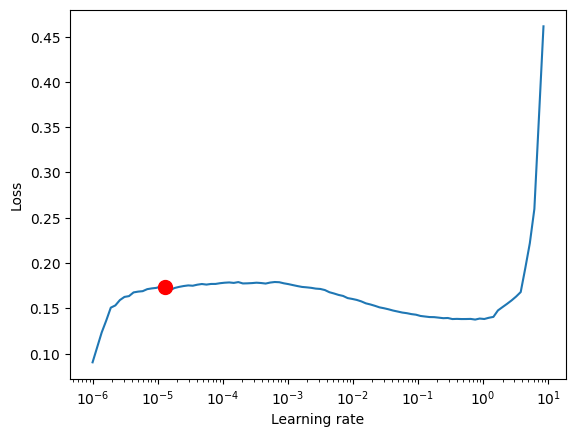

C:\Users\Jones\AppData\Local\Temp\ipykernel_16744\3343767264.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [12]:
res = Tuner(trainer).lr_find(
    TFT,
    train_dataloaders=trainDataloader,
    val_dataloaders=valDataloader,
    max_lr=10.0,
    min_lr=1e-6
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()